In [1]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
minute = False
hour = True

In [4]:
data = None
if minute:
    data = pd.read_csv("BTCUSDT_5m.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

elif hour:
    data = pd.read_csv("BTCUSDT_1h.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

else:
    if not os.path.exists('./BTCUSDT_DB.csv'):
        data = pd.read_csv("BTCUSDT_1m.csv")
        data = get_dollar_bars(data)
        data.to_csv('./BTCUSDT_DB.csv', sep=',')
    else:
        data = pd.read_csv('./BTCUSDT_DB.csv', sep=',')

handler = NewDataHandler(dataset=data)

In [5]:
crossover_horizon = 3

In [6]:
ma1, ma2, ma_mode = 5, 10, 'normal'
ma_modes = {'exponential': 'EMA', 'normal': 'MA'}
ma_name = ma_modes[ma_mode]
k1, k2 = 5, 10

handler.data = ma_crossover_labelling(handler.data, ma1, ma2, crossover_horizon, ma_mode)

handler.data = add_kendall_tau(handler.data, k1)
handler.data = add_kendall_tau(handler.data, k2)
handler.data = add_ichimoku(handler.data)
ichimoku_cols = ['ABOVE_ICHIMOKU_9', 'ABOVE_ICHIMOKU_26', 'Close_ICHIMOKU_9_PERC_DIFF', 'Close_ICHIMOKU_26_PERC_DIFF']

handler.add_indicators([Indicators.RSI, Indicators.MACD,
                       Indicators.ADX])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.LOG_RET])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

# handler.data.drop('NTrades', axis=1, inplace=True)

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
predict_data[f'{ma_name}{ma1} Var'], predict_data[f'{ma_name}{ma2} Var'] = handler.data[f'{ma_name}{ma1} Var'], handler.data[f'{ma_name}{ma2} Var']
predict_data[f'Close_{ma_name}{ma1}_PERC_DIFF'], predict_data[f'Close_{ma_name}{ma2}_PERC_DIFF'] = handler.data[f'Close_{ma_name}{ma1}_PERC_DIFF'], handler.data[f'Close_{ma_name}{ma2}_PERC_DIFF']
predict_data[f'{ma_name}{ma1}_{ma_name}{ma2}_PERC_DIFF'] = handler.data[f'{ma_name}{ma1}_{ma_name}{ma2}_PERC_DIFF']
predict_data[f'{ma_name}{ma1} UP'], predict_data[f'{ma_name}{ma2} UP'] = (handler.data[f'{ma_name}{ma1}'] > handler.data[f'{ma_name}{ma2}']) * 1, (handler.data[f'{ma_name}{ma1}'] < handler.data[f'{ma_name}{ma2}']) * 1
predict_data[ichimoku_cols] = handler.data[ichimoku_cols]
predict_data.reset_index(drop=True, inplace=True)

Index(['MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9'], dtype='object')


C:\Users\Alexis\AppData\Local\Temp\ipykernel_5616\2746476105.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\Alexis\AppData\Local\Temp\ipykernel_5616\2746476105.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
C:\Users\Alexis\AppData\Local\Temp\ipykernel_5616\2746476105.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [7]:
standardize_cols = predict_data.drop(['Unix', 'RSI_30-', 'RSI_BTW', 'RSI_70+', 'Target', 'MA5 UP', 'MA10 UP', 'ABOVE_ICHIMOKU_9', 'ABOVE_ICHIMOKU_26'], axis=1).columns

In [8]:
scaler = StandardScaler()
predict_data[standardize_cols] = scaler.fit_transform(predict_data[standardize_cols])

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5616\3159345970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[standardize_cols] = scaler.fit_transform(predict_data[standardize_cols])


In [9]:
handler.data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5_MA10_PERC_DIFF,Label,Kendall_5,Kendall_10,ICHIMOKU_9,ICHIMOKU_26,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX,+DM,-DM,RSI Var,MACD Var,MACD_H Var,ADX Var,-DM Var,+DM Var,LOG_RET
78,1503223200000,4140.00,4142.41,4109.84,4142.41,0.947044,3.915520e+03,11,4150.684,4126.567,0.001206,0.001367,0.001997,-0.003825,-0.005810,-1,0.0,0.511111,4105.6575,4209.300,1,0,-0.008872,0.016148,45.858721,0,1,0,14.007280,10.837074,49.265056,23.254097,25.412669,-0.190295,0.036381,-0.169867,-0.312707,11.805527,-0.239025,-0.003035
79,1503226800000,4104.68,4125.44,4080.00,4106.53,17.281503,7.077746e+04,106,4148.908,4128.967,-0.000428,0.000582,0.010320,0.005464,-0.004806,-1,-0.8,0.200000,4105.6575,4209.300,1,0,-0.000212,0.025026,25.287749,1,0,0,11.370677,6.560377,44.751532,15.549483,32.834362,-0.448573,-0.188231,-0.394636,-0.091617,0.292047,-0.331323,-0.008699
80,1503230400000,4106.53,4125.43,4080.00,4108.47,2.765840,1.133931e+04,48,4139.428,4127.345,-0.002285,-0.000393,0.007535,0.004594,-0.002919,-1,-0.8,0.155556,4105.4850,4209.300,1,0,-0.000727,0.024542,27.910432,1,0,0,9.330139,3.615872,41.742516,11.418591,24.111552,0.103714,-0.179456,-0.448832,-0.067238,-0.265661,-0.265661,0.000472
81,1503234000000,4125.00,4125.00,4063.35,4063.35,1.258162,5.114583e+03,5,4115.152,4124.218,-0.005865,-0.000758,0.012749,0.014980,0.002203,0,-0.8,-0.200000,4062.8800,4167.695,1,0,-0.000116,0.025680,12.545977,1,0,0,4.025785,-1.350786,45.977817,7.410983,25.127879,-0.550491,-0.568518,-1.373571,0.101463,0.042151,-0.350972,-0.011043
82,1503237600000,4096.32,4096.32,4068.50,4096.32,1.465650,6.001136e+03,14,4103.416,4124.550,-0.002852,0.000081,0.001732,0.006892,0.005150,0,-0.6,-0.511111,4053.3425,4167.695,1,0,-0.010492,0.017424,45.456497,0,1,0,2.454160,-2.337929,48.801351,5.782844,19.607468,2.623193,-0.390390,0.730792,0.061411,-0.219693,-0.219693,0.008081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,1686524400000,25895.79,25938.80,25819.66,25925.55,1083.956070,2.805894e+07,28875,26004.458,25931.186,-0.000380,0.000858,0.003044,0.000217,-0.002818,-1,-0.4,0.466667,25850.9675,26070.665,1,0,-0.002877,0.005597,39.173923,0,1,0,40.486013,23.988484,56.258984,11.557916,32.294732,0.311441,-0.057274,-0.260648,-0.073846,-0.214673,-0.214673,0.001148
50868,1686528000000,25925.54,26028.50,25856.84,25965.13,1363.722650,3.535156e+07,38669,25991.306,25952.380,-0.000506,0.000817,0.001008,-0.000491,-0.001498,-1,-0.4,0.333333,25850.9675,26070.665,1,0,-0.004397,0.004064,51.905937,0,1,0,41.254911,19.805906,39.222741,24.455509,22.059850,0.325012,0.018992,-0.174358,-0.302818,-0.316921,1.115910,0.001526
50869,1686531600000,25965.13,26000.00,25891.66,25935.17,1111.029890,2.882563e+07,33125,25953.604,25970.761,-0.001451,0.000708,0.000711,0.001372,0.000661,1,0.0,0.066667,25850.9675,26070.665,1,0,-0.003247,0.005224,41.938611,0,1,0,38.997211,14.038565,27.865245,18.811521,16.968747,-0.192027,-0.054726,-0.291193,-0.289564,-0.230786,-0.230786,-0.001155
50870,1686535200000,25935.17,25959.56,25602.11,25773.47,3157.175120,8.132780e+07,71704,25899.024,25961.269,-0.002103,-0.000365,0.004871,0.007287,0.002403,1,0.0,-0.333333,25850.9675,26070.665,0,0,0.003007,0.011531,16.416844,1,0,0,23.884800,-0.859077,42.135422,8.781565,51.111341,-0.608551,-0.387525,-1.061194,0.512114,2.012087,-0.533182,-0.006254


In [10]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX Var,-DM Var,+DM Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5_MA10_PERC_DIFF,MA5 UP,MA10 UP,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF
0,1503223200000,-0.148934,0.005266,-0.005208,-1.523222,0.048368,-0.040809,0,1,0,-0.347077,-1,-0.042733,0.990267,0.313938,0.519828,0.214469,-0.273412,-0.768371,1,0,1,0,-0.168218,0.356867
1,1503226800000,-0.236444,0.002312,-0.009370,-0.517803,-0.012147,-0.043648,1,0,0,-0.987361,-1,-1.458370,0.353322,-0.127072,0.212331,1.108334,0.392060,-0.634806,1,0,1,0,0.023214,0.529133
2,1503230400000,-0.049318,0.002427,-0.010373,-0.406939,-0.015079,-0.041628,1,0,0,0.049323,-1,-1.458370,0.262330,-0.628297,-0.169328,0.809261,0.329758,-0.383740,1,0,1,0,0.011849,0.519742
3,1503234000000,-0.270976,-0.002691,-0.027495,0.360236,-0.013461,-0.044252,1,0,0,-1.252259,0,-1.458370,-0.465606,-1.594453,-0.312209,1.369217,1.073845,0.297637,0,1,1,0,0.025353,0.541814
4,1503237600000,0.804333,-0.000348,0.011469,0.178099,-0.014837,-0.040214,0,1,0,0.909371,0,-1.104461,-1.102551,-0.781321,0.016064,0.185996,0.494357,0.689703,0,1,1,0,-0.204018,0.381636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50789,1686524400000,0.021064,0.004034,-0.006889,-0.436987,-0.014811,-0.040060,0,1,0,0.125717,-1,-0.750552,0.899275,-0.114195,0.320472,0.326843,0.016180,-0.370260,1,0,1,0,-0.035683,0.152161
50790,1686528000000,0.025662,0.005038,-0.005291,-1.478250,-0.015348,0.000863,0,1,0,0.168368,-1,-0.750552,0.626299,-0.148091,0.304657,0.108216,-0.034577,-0.194662,1,0,1,0,-0.069284,0.122419
50791,1686531600000,-0.149521,0.004068,-0.007454,-1.417976,-0.014896,-0.040556,0,1,0,-0.134560,1,-0.042733,0.080346,-0.403096,0.261941,0.076279,0.098925,0.092507,0,1,1,0,-0.043859,0.144924
50792,1686535200000,-0.290648,-0.000310,-0.021711,2.227693,-0.003107,-0.049856,1,0,0,-0.710993,1,-0.042733,-0.738582,-0.579187,-0.158618,0.523161,0.522655,0.324281,0,1,0,0,0.094379,0.267292


In [11]:
handler.data['LOG_RET'].abs().describe()

count    50794.000000
mean         0.005122
std          0.007214
min          0.000000
25%          0.001245
50%          0.002891
75%          0.006125
max          0.201033
Name: LOG_RET, dtype: float64

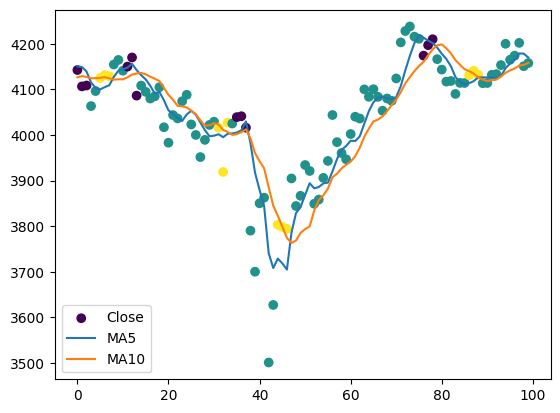

In [12]:
plt.scatter(range(100), handler.data['Close'][0:100], c=handler.data['Label'][0:100], label="Close")
plt.plot(range(100), handler.data[f'{ma_name}{ma1}'][0:100], label=f"{ma_name}{ma1}")
plt.plot(range(100), handler.data[f'{ma_name}{ma2}'][0:100], label=f"{ma_name}{ma2}")
plt.legend()
plt.show()

In [13]:
seq_length = 15
dataset = TSDataset(predict_data, seq_length)

In [14]:
train_indices = range(0, round(0.7 * len(dataset)), int(seq_length / 3))
val_indices = range(round(0.7 * len(dataset)), round(0.9 * len(dataset)), int(seq_length / 5))
test_indices = range(round(0.9 * len(dataset)), len(dataset))

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices) # Validation set will be training set for Meta Labelling
test_set = torch.utils.data.Subset(dataset, test_indices)

In [15]:
print(train_indices)
print(val_indices)
print(test_indices)

range(0, 35545, 5)
range(35545, 45701, 3)
range(45701, 50779)


In [16]:
label_distribution = (predict_data.loc[train_set.indices, 'Target'].value_counts() / predict_data.loc[train_set.indices, 'Target'].shape[0]).sort_index().to_list()
display(predict_data.loc[train_set.indices, 'Target'].value_counts())
label_distribution

Target
 0    4931
 1    1091
-1    1087
Name: count, dtype: int64

[0.15290476860317906, 0.6936277957518638, 0.1534674356449571]

In [17]:
class_weights = [1 / p for p in label_distribution]
print(class_weights)
class_weights = [6, 3, 6] # BEST ONE SO FAR
weights = [class_weights[torch.argmax(label)] for _, label in train_set]
train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_set), replacement=True)
# train_sampler = None

[6.54001839926403, 1.441695396471304, 6.516040329972502]


In [18]:
input_size = dataset.size
hidden_size = 500
batch_size = 16
dynamic_batch = False
num_layers = 2
output_size = predict_data['Target'].unique().size
lstm_model = LSTMModel(input_size, hidden_size,
                       num_layers, output_size, bidirectional=True).to(device)

In [19]:
weights = torch.Tensor(label_distribution).to(device)
losses, accuracies, val_losses, val_accuracies, _, _ = train_lstm(lstm_model, train_set, val_set, 50, 0.00001,
           batch_size, num_layers, hidden_size, device, train_sampler, class_weights=None, model_name=f'crossover_{seq_length}_to_{crossover_horizon}', save=False, dynamic_batch=False)

Epoch: 1/50 -- [2225/7109 (100.0%)]	Loss: 0.869940203629183	Accuracy: 0.727	Time taken: 4.984375	Validation Loss: 0.7691036462783813 || Validation Accuracy: 0.803
Epoch: 2/50 -- [2225/7109 (100.0%)]	Loss: 0.7398603723290261	Accuracy: 0.825	Time taken: 4.625	Validation Loss: 0.7299702763557434 || Validation Accuracy: 0.821
Epoch: 3/50 -- [2225/7109 (100.0%)]	Loss: 0.7172246111912673	Accuracy: 0.837	Time taken: 4.734375	Validation Loss: 0.7254789471626282 || Validation Accuracy: 0.825
Epoch: 4/50 -- [2225/7109 (100.0%)]	Loss: 0.7037661097022925	Accuracy: 0.848	Time taken: 4.53125	Validation Loss: 0.7198869585990906 || Validation Accuracy: 0.828
Epoch: 5/50 -- [2225/7109 (100.0%)]	Loss: 0.70963877399316	Accuracy: 0.839	Time taken: 4.296875	Validation Loss: 0.7237120866775513 || Validation Accuracy: 0.824
Epoch: 6/50 -- [2225/7109 (100.0%)]	Loss: 0.704084837436676	Accuracy: 0.844	Time taken: 4.328125	Validation Loss: 0.7203983068466187 || Validation Accuracy: 0.828
Epoch: 7/50 -- [2225/710

In [20]:
torch.cuda.empty_cache()

In [24]:
# lstm_model = torch.load(f'./models/crossover_{seq_length}_to_{crossover_horizon}.pt').to(device)

In [25]:
eval_lstm(lstm_model, test_set, 64, num_layers, hidden_size, device)

Accuracy : 0.8351713272942103 || Loss : 0.7136461734771729
Confusion matrix : 
[[ 713.  111.    0.]
 [ 322. 2826.  282.]
 [   0.  122.  702.]]


(tensor([[9.8352e-01, 1.6481e-02, 6.8458e-08],
         [1.6333e-02, 9.8367e-01, 1.6497e-07],
         [3.2596e-05, 9.9997e-01, 6.5913e-07],
         ...,
         [8.7905e-07, 9.6987e-01, 3.0132e-02],
         [1.3207e-09, 9.9998e-01, 1.7791e-05],
         [1.9910e-09, 9.9999e-01, 7.1016e-06]], device='cuda:0'),
 tensor([[0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         ...,
         [0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 1.]], device='cuda:0'))

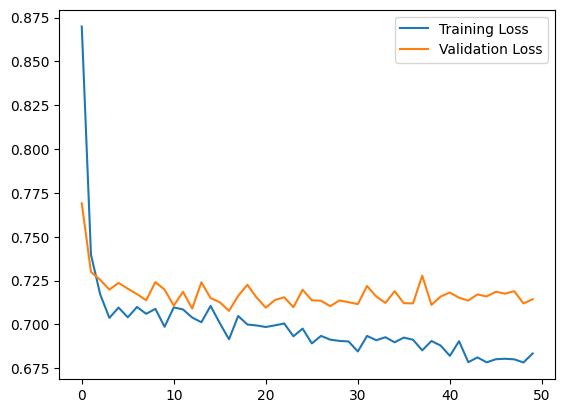

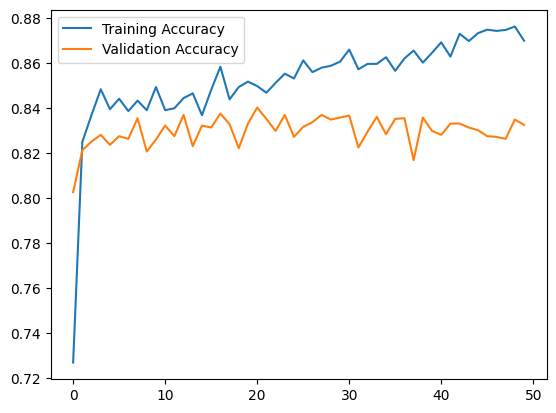

In [23]:
plt.plot([float(loss) for loss in losses], label="Training Loss")
plt.plot([float(loss) for loss in val_losses], label="Validation Loss")
plt.legend()
plt.show()
plt.plot([float(acc) for acc in accuracies], label="Training Accuracy")
plt.plot([float(acc) for acc in val_accuracies], label="Validation Accuracy")
plt.legend()
plt.show()